In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

In [4]:
celebs = os.listdir("../cropped_faces")
faces = []

for celeb in celebs:
    faces.append(np.asarray(Image.open("../cropped_faces/{}".format(celeb))))

face_array = np.array(faces)
red, green, blue = np.split(face_array, 3, axis=3)

In [5]:
def get_random_face():
    index = np.random.randint(0, len(face_array))
    return faces[index], index


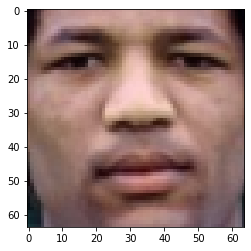

In [6]:
plt.imshow(get_random_face()[0], cmap=plt.cm.rainbow)


In [7]:
def pca(X, n_pc):
    mean = np.mean(X, axis=0)
    centered_data = X - mean # Subtracting the mean from the data
    U, S, V = np.linalg.svd(centered_data) # Taking the SVD from the data
    components = V[:n_pc] # Extracting the principal components
    projected = U[:,:n_pc]*S[:n_pc]

    return projected, components, mean, centered_data

In [8]:
def eigenfaces(data, faces=50):
    samples, h, w, d = data.shape
    X = data.reshape(samples, h*w) # vectorizing the images
    P, C, M, Y = pca(X, n_pc=faces) # running PCA with the number of principal components specified
    return C.reshape((faces, h, w)), P, C, M, Y #reshaping the principal components to be images

def reconstruct(mean_centered, components, mean, index):
    weights = np.dot(mean_centered, components.T)
    centered_vector = np.dot(weights[index, :], components) # applying weights to each of the components
    recovered = (mean + centered_vector).reshape(64, 64)
    return recovered

In [9]:
def accuracy(original, reconstruction):
    difference = original - reconstruction
    sum = np.sum(np.abs(difference))
    return sum / np.sum(original)

In [10]:
def list_to_diagonal(list, size):
    output = np.zeros((len(list), len(list)))
    if size != 0:
        output = np.zeros((size, size))
    for x in range(len(list)):
        output[x, x] = list[x]
    return output

def image_low_rank_approximation(array, rank):
    U_red, S_red, V_red = np.linalg.svd(array[:,:,0])
    U_green, S_green, V_green = np.linalg.svd(array[:,:,1])
    U_blue, S_blue, V_blue = np.linalg.svd(array[:,:,2])
    red_approx = np.zeros((64, 64))
    green_approx = np.zeros((64, 64))
    blue_approx = np.zeros((64, 64))
    for x in range(rank):
        red_approx += S_red[x] * np.outer(U_red.transpose()[x], V_red[x])
        green_approx += S_green[x] * np.outer(U_green.transpose()[x], V_green[x])
        blue_approx += S_blue[x] * np.outer(U_blue.transpose()[x], V_blue[x])
    return np.dstack((red_approx, green_approx, blue_approx))


In [21]:
lr_accuracies = {}

for x in tqdm(range(1, 65, 3)):
    lr_accuracies[x] = list()
    for face in tqdm(range(100)):
        lr_accuracies[x].append(1 - accuracy(faces[face], image_low_rank_approximation(faces[face], x)))

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

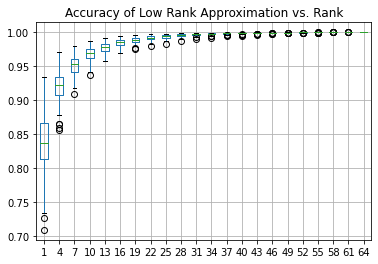

In [24]:
lr_accuracy_df = pd.DataFrame.from_dict(lr_accuracies)
plt.title("Accuracy of Low Rank Approximation vs. Rank")
lr_accuracy_df.boxplot();

In [26]:
lr_faces = [ image_low_rank_approximation(face, 20) for face in faces ]
lr_array = np.array(lr_faces)
red, green, blue = np.split(lr_array, 3, axis=3)

In [27]:
eigenface_dict = dict()
accuracies = dict()

for num_faces in range(50, 500, 50):
    print("Computing {} Eigenfaces".format(num_faces))
    red_eigenface_array, P_r, C_r, M_r, Y_r = eigenfaces(red, num_faces)
    green_eigenface_array, P_g, C_g, M_g, Y_g = eigenfaces(green, num_faces)
    blue_eigenface_array, P_b, C_b, M_b, Y_b = eigenfaces(blue, num_faces)
    print("Finished Eigenfaces")

    eigenface_dict[num_faces] = ((red_eigenface_array, P_r, C_r, M_r, Y_r), (green_eigenface_array, P_g, C_g, M_g, Y_g), (blue_eigenface_array, P_b, C_b, M_b, Y_b))
    accuracies[num_faces] = list()

    for face in tqdm(range(100)):
        reconstruction = np.dstack((
            reconstruct(Y_r, C_r, M_r, face),
            reconstruct(Y_g, C_g, M_g, face),
            reconstruct(Y_b, C_b, M_b, face)
        ))

        accuracies[num_faces].append(accuracy(faces[face], reconstruction))

Computing 50 Eigenfaces
Finished Eigenfaces


  0%|          | 0/100 [00:00<?, ?it/s]

Computing 100 Eigenfaces
Finished Eigenfaces


  0%|          | 0/100 [00:00<?, ?it/s]

Computing 150 Eigenfaces
Finished Eigenfaces


  0%|          | 0/100 [00:00<?, ?it/s]

Computing 200 Eigenfaces
Finished Eigenfaces


  0%|          | 0/100 [00:00<?, ?it/s]

Computing 250 Eigenfaces
Finished Eigenfaces


  0%|          | 0/100 [00:00<?, ?it/s]

Computing 300 Eigenfaces
Finished Eigenfaces


  0%|          | 0/100 [00:00<?, ?it/s]

Computing 350 Eigenfaces
Finished Eigenfaces


  0%|          | 0/100 [00:00<?, ?it/s]

Computing 400 Eigenfaces
Finished Eigenfaces


  0%|          | 0/100 [00:00<?, ?it/s]

Computing 450 Eigenfaces
Finished Eigenfaces


  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
accuracy_df = pd.DataFrame.from_dict(accuracies)
accuracy_df

,50,100,150,200,250,300,350,400,450
0,0.102692,0.069139,0.053754,0.045429,0.036987,0.032233,0.029204,0.025994,0.023295
1,0.103454,0.067084,0.051467,0.040087,0.034412,0.030010,0.025492,0.022764,0.020380
2,0.067733,0.047300,0.037915,0.031394,0.026990,0.022964,0.020845,0.018411,0.015865
3,0.081415,0.054282,0.040883,0.033731,0.029177,0.025721,0.022665,0.020074,0.018819
4,0.072596,0.054165,0.047281,0.040248,0.036039,0.031037,0.028588,0.026693,0.023962
...,...,...,...,...,...,...,...,...,...
95,0.100281,0.075062,0.057355,0.051206,0.045345,0.040785,0.037045,0.034538,0.031504
96,0.067864,0.052960,0.044289,0.039742,0.035891,0.032362,0.028265,0.026030,0.023967
97,0.076749,0.057248,0.046134,0.036746,0.032434,0.028405,0.025488,0.022903,0.021256
98,0.110397,0.085448,0.069496,0.059030,0.051824,0.045386,0.042519,0.038777,0.036175


In [30]:
accuracy_df = 1 - accuracy_df

<AxesSubplot:title={'center':'Accuracy of Reconstruction vs. Number of Eigenfaces'}>

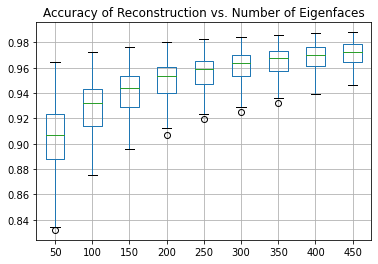

In [31]:
plt.title("Accuracy of Reconstruction vs. Number of Eigenfaces")
accuracy_df.boxplot()